<a id='Table of Contents'></a><h1>Table of Contents</h1>

- <a href='#introduction'>Introduction</a> 
- <a href='#imports'>Import and install required libraries</a>  
- <a href='#set_fitting'>Setting of fitting</a>  
- <a href='#run_fit'>Running the fit</a>  
- <a href='#results'>Showing the results</a> 

(<a href='#Table of Contents'>Top</a>)<a id='introduction'></a><h2>Introduction</h2>

<div class="alert alert-block alert-info">
The objective of this notebook is to show how to use the isotropic rotational diffusion model `IsotropicRotationalDiffusion` to perform some 
fits using [bumps](https://github.com/bumps/bumps).
</div>

The **reference data** were generated using the above model with the following parameters:  
- Radius = 1.10 Angstrom 
- D_rot = 0.125 meV

The model was convoluted with a Gaussian resolution function 
of FWHM = 0.1 meV, centered randomly in the range \[-0.01, +0.01\] meV.

Finally the data were sampled randomly from a Poisson distribution.

The data do not have a background.

(<a href='#Table of Contents'>Top</a>)<a id='imports'></a><h2> Import python modules for plotting, fitting... </h2>

In [1]:
# Imported required libraries
from __future__ import print_function
import sys
import os

import ipywidgets

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# install bumps (if not already installed)
import pkgutil
if not pkgutil.find_loader("bumps"):
    !{sys.executable} -m pip install bumps
    
# check version of bumps installed
# Information message if installed version not recent enough
import bumps

from distutils.version import StrictVersion
if StrictVersion(bumps.__version__) <= StrictVersion('0.7.6'):
    print("""The version of bumps installed is not recent 
    enough to run the examples. 
    Please update bumps. The minimum version required is 0.7.8""")

 (<a href='#Table of Contents'>Top</a>)<a id='set_fitting'></a><h2>Setting of fitting </h2>
<h3> load data, prepare data, create fitting model and set initial guesses </h3>

In [3]:
import h5py
import QENSmodels
import numpy as np
from scipy.integrate import simps
from bumps.names import *
from bumps.fitters import fit
from bumps.formatnum import format_uncertainty

path_to_data = './data/'

# Read the sample
f = h5py.File(path_to_data + 'IsoRot_Sample.hdf', 'r')
hw = f['entry1']['data1']['X'][:]
q = f['entry1']['data1']['Y'][:]
sqw = np.transpose(f['entry1']['data1']['DATA'][:])
err = np.transpose(f['entry1']['data1']['errors'][:])
f.close()

# Read resolution
f = h5py.File(path_to_data + 'IsoRot_Resol.hdf', 'r')
res = np.transpose(f['entry1']['data1']['DATA'][:])
f.close()

# Force resolution function to have unit area
for i in range(len(q)):
    area = simps(res[:,i], hw)
    res[:,i] /= area   

# Fitting model 
def model_convol(x, q, scale=1, center=0, radius=1, DR=1, resolution=None):
    model = QENSmodels.sqwIsotropicRotationalDiffusion(x, q, scale, center, radius, DR)
    return np.convolve(model, resolution/resolution.sum(), mode='same')

# Fit
M = []

# First dataset: wavelength=5 Angstrom 
for i in range(len(q)):

    # Bumps fitting model
    Mq = Curve(model_convol, hw, sqw[:,i], err[:,i], q=q[i],          
               scale=1000, center=0.0, radius=1.0, DR=0.1, resolution=res[:, i])
    Mq.scale.range(0, 1e5)
    Mq.center.range(-0.1, 0.1)
    Mq.radius.range(0, 3)
    Mq.DR.range(0, 2)
    
    # Q-independent parameters
    if i == 0:
        QR = Mq.radius
        QDR = Mq.DR
    else:
        Mq.radius = QR
        Mq.DR = QDR
    M.append(Mq)
        
problem = FitProblem(M)

<h3> Choice of minimizer for bumps </h3>

In [4]:
w_choice_minimizer = ipywidgets.widgets.Dropdown(
    options={'Levenberg-Marquardt': "lm", 
             'Nelder-Mead Simplex': "amoeba", 
             'DREAM': "dream", 
             'Differential Evolution': "de", 
             'Quasi-Newton BFGS': "newton", 
             'Random Lines (experimental)': "rl", 
             'Particle Swarm (experimental)': "ps", 
             'Parallel Tempering (experimental)': "pt"},
    value="lm",
    description='Minimizer:',)

display(w_choice_minimizer)

RHJvcGRvd24oZGVzY3JpcHRpb249dSdNaW5pbWl6ZXI6JywgaW5kZXg9NCwgb3B0aW9ucz17J1F1YXNpLU5ld3RvbiBCRkdTJzogJ25ld3RvbicsICdSYW5kb20gTGluZXMgKGV4cGVyaW1lbnTigKY=


<h3> Setting for running bumps </h3>

In [5]:
# CHOICE OF MINIMIZER
minimiser = w_choice_minimizer.value

# NUMBER OF STEPS WHEN RUNNING THE FIT
steps = 100

Initial chisq 1067.0559(62)


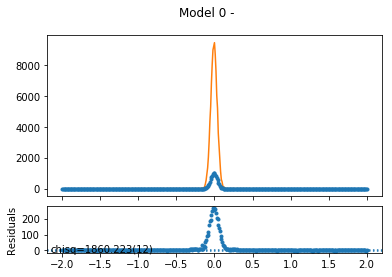

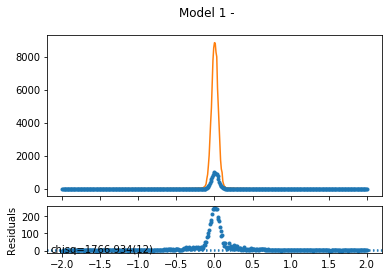

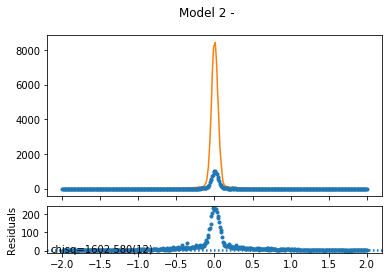

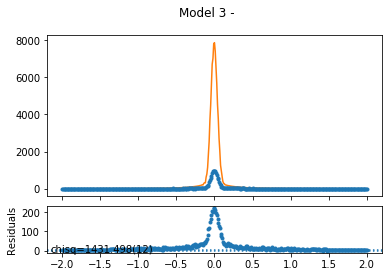

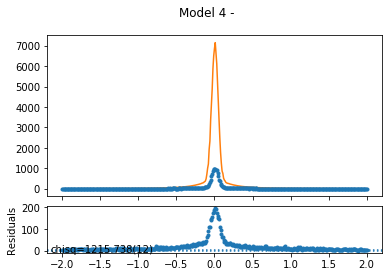

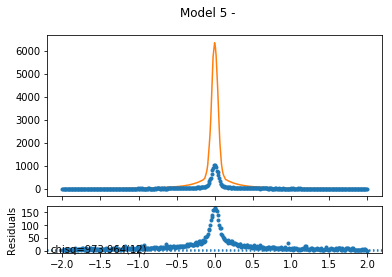

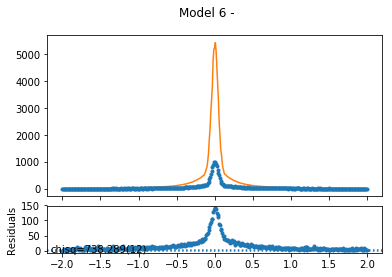

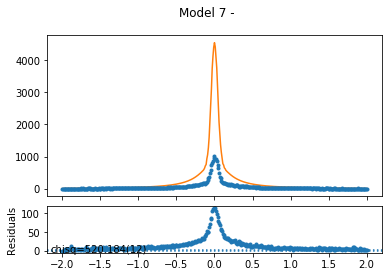

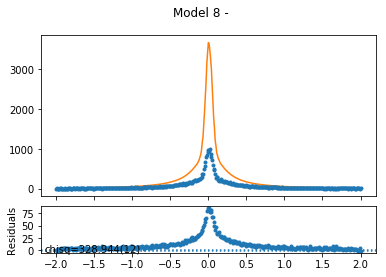

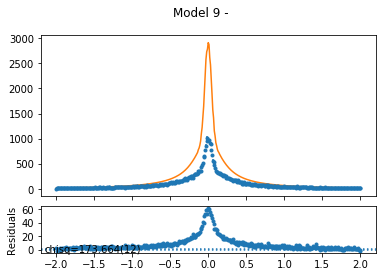

In [6]:
# Preview of the settings
print('Initial chisq', problem.chisq_str())
problem.plot()

(<a href='#Table of Contents'>Top</a>)<a id='run_fit'></a><h2>Running the fit</h2>

Run the fit using the *minimizer* defined above with a number of *steps* also specified above.

In [7]:
result = fit(problem, 
             method=w_choice_minimizer.value, 
             steps=steps, 
             verbose=True)

final chisq 1.1808(62)
=== Uncertainty est. from curvature: par    dx           dx/sqrt(chisq) ===
                                      DR 0.11291(98)     0.11291(91)    
                                  center 0.004(37)       0.004(34)      
                                  radius 1.0469(25)      1.0469(23)     
                                   scale 106.6(10)       106.65(95)     
                                  center -0.005(14)      -0.005(12)     
                                   scale 106.9(11)       106.95(97)     
                                  center 4.2(93)e-3      4.2(86)e-3     
                                   scale 119.8(11)       119.8(10)      
                                  center 0.3(55)e-3      0.3(50)e-3     
                                   scale 130.7(12)       130.7(11)      
                                  center -0.7(59)e-3     -0.7(54)e-3    
                                   scale 147.8(12)       147.8(11)      
                         

(<a href='#Table of Contents'>Top</a>)<a id='results'></a><h2>Showing the results </h2>

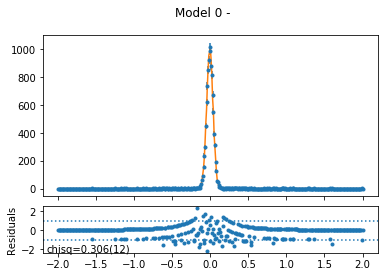

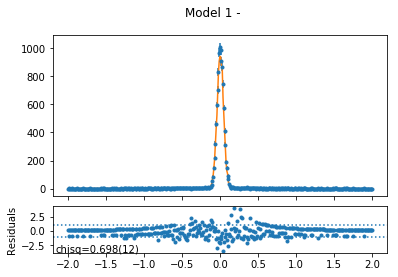

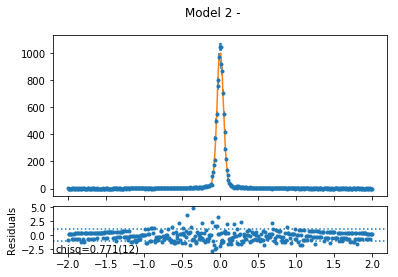

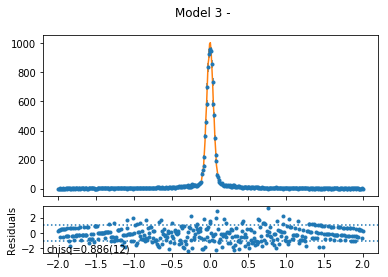

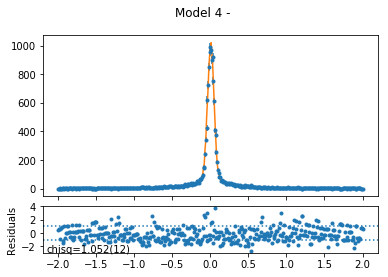

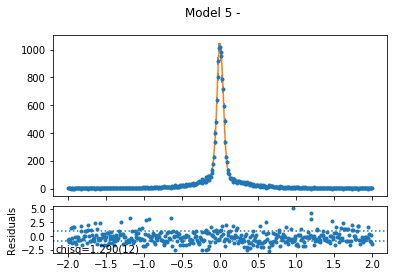

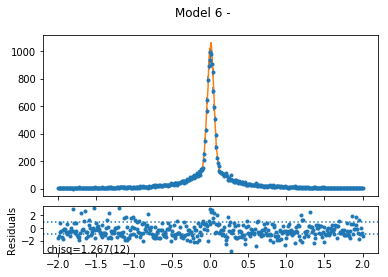

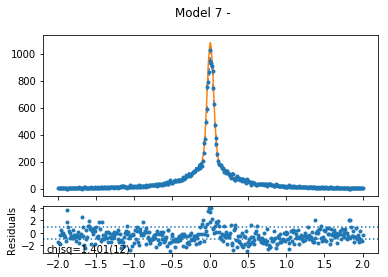

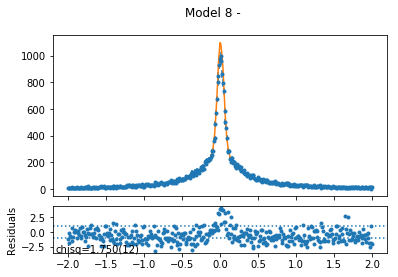

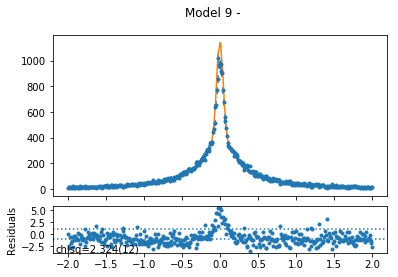

In [8]:
problem.plot()

In [9]:
# Print chi**2 and parameters' values after fit
print("final chisq", problem.chisq_str())
for k, v, dv in zip(problem.labels(), result.x, result.dx):
    print(k, ":", format_uncertainty(v, dv))

final chisq 1.1808(62)
DR : 0.11291(98)
center : 0.004(37)
radius : 1.0469(25)
scale : 106.6(10)
center : -0.005(14)
scale : 106.9(11)
center : 4.2(93)e-3
scale : 119.8(11)
center : 0.3(55)e-3
scale : 130.7(12)
center : -0.7(59)e-3
scale : 147.8(12)
center : -0.7(43)e-3
scale : 173.2(13)
center : -0.5(35)e-3
scale : 210.1(15)
center : -1.7(30)e-3
scale : 262.4(17)
center : -3.5(26)e-3
scale : 339.0(19)
center : 0.9(22)e-3
scale : 457.5(23)
